In [63]:
# import libraries 
import numpy as np 
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import pickle 
from IPython.html import widgets 
import ipywidgets 
from scipy.signal import find_peaks_cwt

%matplotlib inline 

# AbS Sobel Thresh 

In [64]:
# Read an image and grayscale it 
image = mpimg.imread('output_images/test3_undist.jpg')

'''
take an absolute value and apply a threshold. 
'''
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == "x": 
        sobel = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    elif orient == "y":
        sobel = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=sobel_kernel)
    else:
        pass 
    # Take the absolute value of the derivative or gradient 
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 -255) -> convert to uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude is hight than thresh_min and lower than thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel>=thresh_min) & (scaled_sobel<=thresh_max)] = 1
    return sbinary 


Text(0.5, 1.0, 'Threshold Gradient')

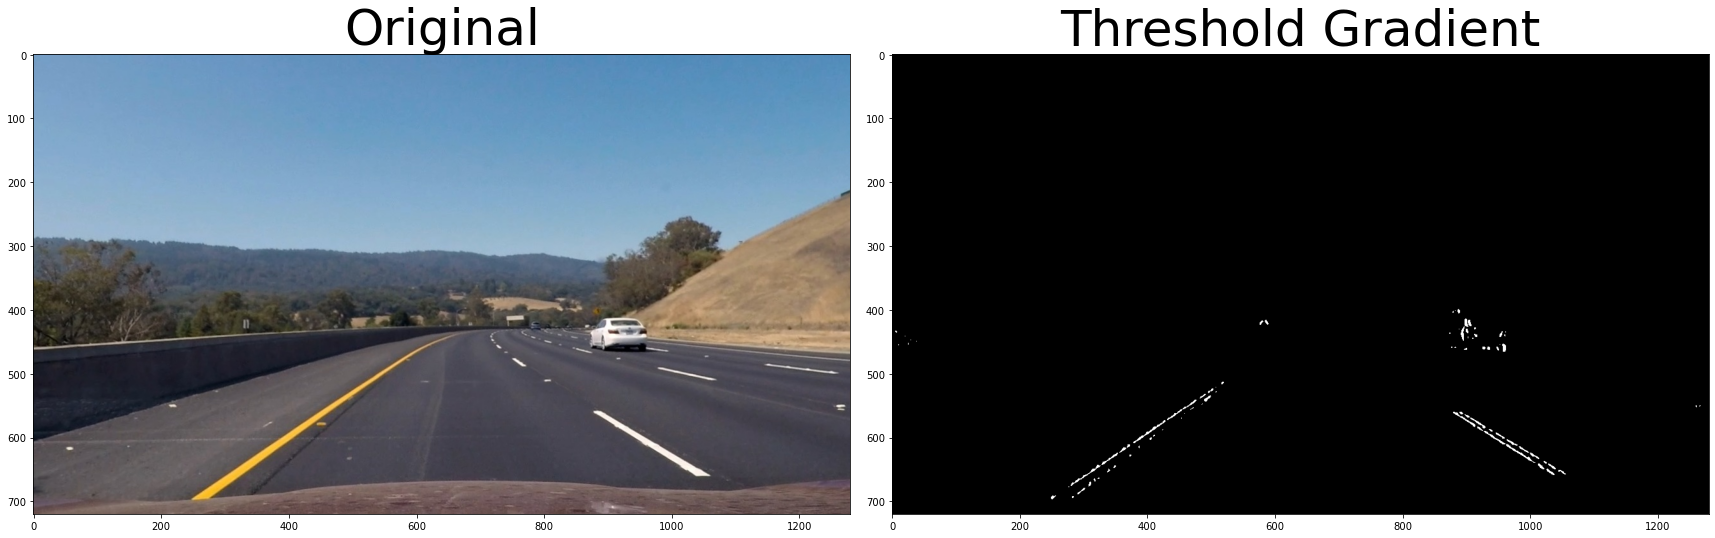

In [65]:
# Function Call 
HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
S = HLS[:,:,2]
grad_binary = abs_sobel_thresh(S,orient='x',sobel_kernel=13,thresh_min=90, thresh_max=255)
# Plot the result 
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original', fontsize=50)
ax2.imshow(grad_binary,cmap = 'gray')
ax2.set_title('Threshold Gradient', fontsize=50)

In [66]:
@widgets.interact(orient=widgets.RadioButtons(options=['x', 'y'],value='x',description='Orient:',disabled=False),
                                ksize = widgets.IntSlider(min=3,max=25,step=2,value=11),
                                min_thresh=widgets.IntSlider(min=0,max=255,step=1,value=23),
                                max_thresh=widgets.IntSlider(min=0,max=255,step=1,value=77))
def thresh(orient,ksize,min_thresh,max_thresh):
    HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    S= HLS[:,:,2]
    grad_binary = abs_sobel_thresh(S, sobel_kernel=ksize,orient=orient, thresh_min=min_thresh, thresh_max=max_thresh)
    
    plt.figure(figsize=(10,8))
    plt.imshow(grad_binary,cmap="gray")
    plt.title("Kernel Size:%s Min_Thresh:%s, Max_Thresh:%s"%(str(ksize),str(min_thresh),str(max_thresh)),fontsize=20)

interactive(children=(RadioButtons(description='Orient:', options=('x', 'y'), value='x'), IntSlider(value=11, …

# Magnitude Thresh 

In [67]:
# Read in an image and grayscale it 
image = mpimg.imread('output_images/test2_undist.jpg')


'''
Compute the magnitude of the gradient and apply a threshold
'''
def mag_thresh(img, sobel_kernel=3,mag_thresh=(0,255)):
    # Convert to grayscale 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y seprately 
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # Calculate the magnitude 
    sobelxy = np.sqrt(sobelx**2+sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.unit8
    absxy = np.absolute(sobelxy) 
    scale_factor = np.max(absxy)/255
    absxy = (absxy/scale_factor).astype(np.int8)
    binary_output = np.zeros_like(absxy)
    binary_output[(absxy>mag_thresh[0])&(absxy >mag_thresh[1])] = 1
    return binary_output

    
    
    


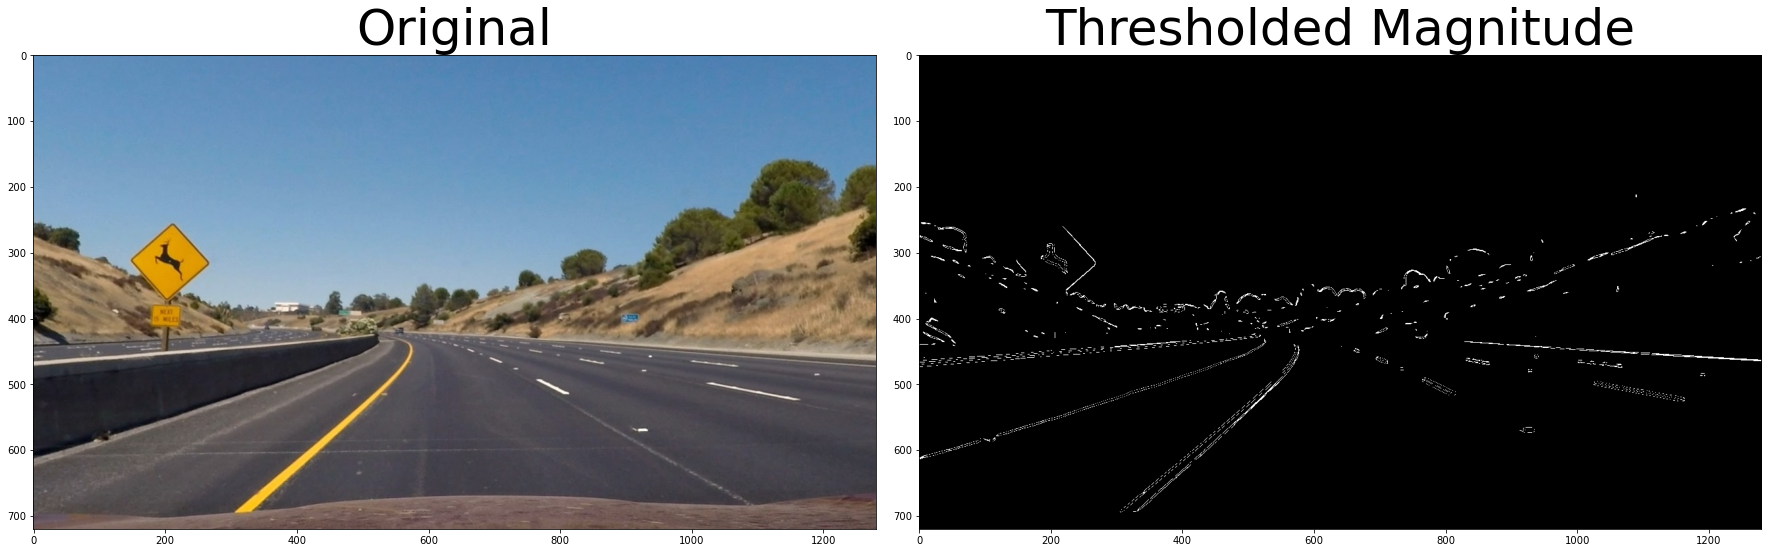

In [68]:
# Run the function 
mag_binary = mag_thresh(image, sobel_kernel=11, mag_thresh=(30,100))
# Plot the result 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.imshow(image,cmap='gray')
ax1.set_title('Original',fontsize=50)
ax2.imshow(mag_binary,cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

In [69]:
image = mpimg.imread('output_images/test3_undist.jpg')
@widgets.interact(sobel_kernel=widgets.IntSlider(min=3,max=25,step=2,value=11),
                                 min_thresh = widgets.IntSlider(min=0,max=255,step=1,value=30),
                                 max_thresh = widgets.IntSlider(min=0,max=255,step=1,value=100))
def mag(sobel_kernel,min_thresh,max_thresh):
    mag_binary = mag_thresh(image, sobel_kernel=sobel_kernel, mag_thresh=(min_thresh, max_thresh))
    plt.figure(figsize=(12,6))
    plt.imshow(mag_binary,cmap="gray")
    plt.title("Sobel Kernel:%s Min Thresh:%s Max Thresh:%s"%(str(sobel_kernel),str(min_thresh),str(max_thresh)),fontsize=20)
    
    

interactive(children=(IntSlider(value=11, description='sobel_kernel', max=25, min=3, step=2), IntSlider(value=…

# Dir Threshold

In [70]:
# Read in an image 
image = mpimg.imread('output_images/test2_undist.jpg')
# compute the direction of the gradient and apply a threshold 

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Take the gradient in x and y seprately 
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    #Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    #Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctan = np.arctan2(abs_sobely,abs_sobelx)
    #Create a binary mask where direction thresholds are met
    sarctan = np.zeros_like(arctan)
    sarctan[(arctan>=thresh[0])&(arctan<=thresh[1])]=1
    # Return this mask as your binary_output image
    return sarctan
    

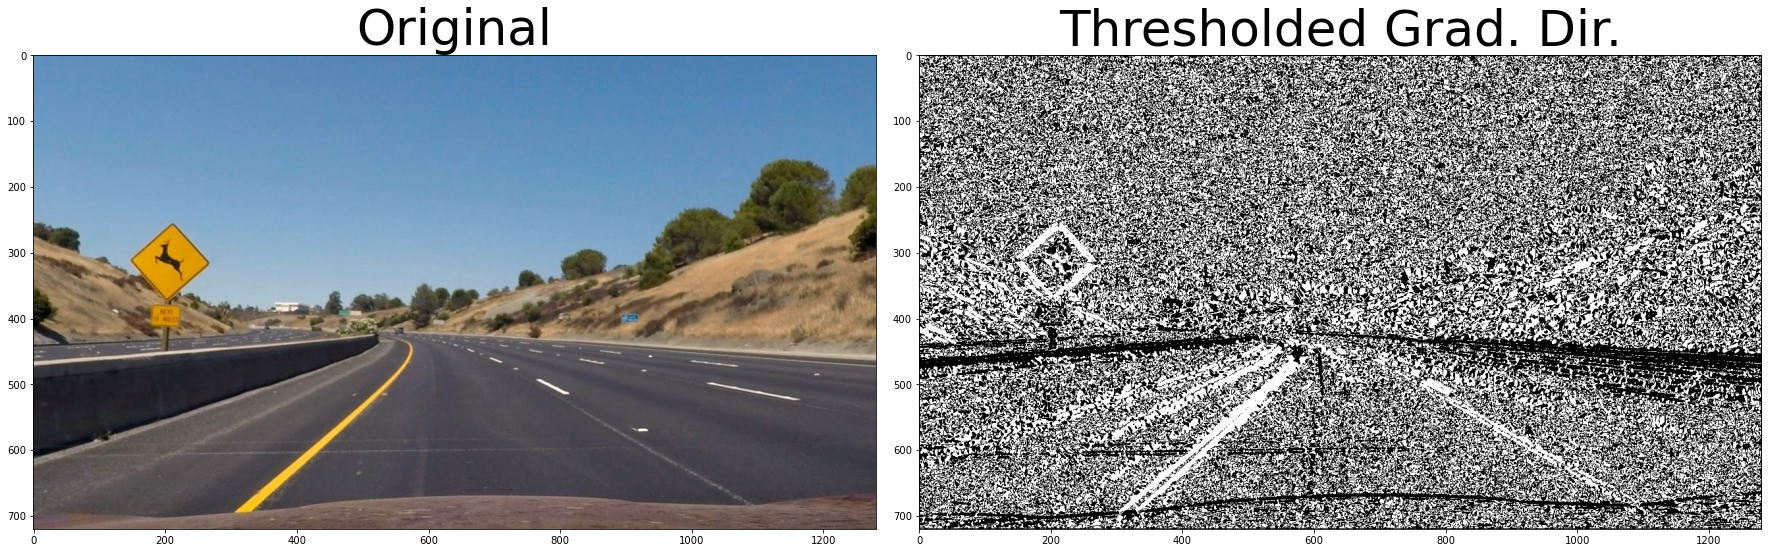

In [71]:
dir_binary = dir_threshold(image, sobel_kernel=9, thresh=(0.5, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [72]:
@widgets.interact(sobel_kernel=widgets.IntSlider(min=3,max=25,step=2,value=15),
                                 min_thresh = widgets.FloatSlider(min=0,max=np.pi/2,step=0.05,value=0.7),
                                 max_thresh = widgets.FloatSlider(min=0,max=np.pi/2,step=0.05,value=1.3))
def mag(sobel_kernel,min_thresh,max_thresh):
    dir_binary = dir_threshold(image, sobel_kernel=sobel_kernel, thresh=(min_thresh, max_thresh))
    histogram = np.sum(dir_binary, axis=0)
    plt.imshow(dir_binary,cmap="gray")

interactive(children=(IntSlider(value=15, description='sobel_kernel', max=25, min=3, step=2), FloatSlider(valu…

# Color Space (HLS)

In [73]:
# Read in an image 
image = mpimg.imread('output_images/test3_undist.jpg')

"""
compute the direction of the gradient and applies a threshold
"""
def color_threshold_HLS(img, color_space,thresh = (0,255)):
    # Convert to grayscale
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = HLS[:,:,0]
    L = HLS[:,:,1]
    S = HLS[:,:,2]
    
    if color_space == "H": 
        binary = np.zeros_like(H)
        binary[(H>=thresh[0])&(H<=thresh[1])] = 1
        retval, color_space_binary = cv2.threshold(H.astype('uint8'),thresh[0],thresh[1],cv2.THRESH_BINARY)
        print('Color Space:', color_space)
    elif color_space == "L":
        binary = np.zeros_like(L)
        binary[(L>=thresh[0])&(L<=thresh[1])] = 1
        retval, color_space_binary = cv2.threshold(L.astype('uint8'),thresh[0],thresh[1],cv2.THRESH_BINARY)
        print('Color Space:', color_space)
    elif color_space == "S":
        binary = np.zeros_like(S)
        binary[(S>=thresh[0])&(S<=thresh[1])] = 1
        retval, color_space_binary = cv2.threshold(S.astype('uint8'),thresh[0],thresh[1],cv2.THRESH_BINARY)
        print('Color Space:', color_space)
    return color_space_binary 


In [74]:
@widgets.interact(color_space=widgets.RadioButtons(options=['H', 'L', 'S'],value='S',description='Color Space:',disabled=False),
                                   min_thresh = widgets.IntSlider(min=0,max=255,step=1,value=167),
                                 max_thresh = widgets.IntSlider(min=0,max=255,step=1,value=233))
def color_thresh(color_space,min_thresh,max_thresh):
    b_img = color_threshold_HLS(image,color_space,thresh=(min_thresh,max_thresh))
    print(b_img.shape)
    plt.imshow(b_img[460:,100:1050],cmap='gray')

interactive(children=(RadioButtons(description='Color Space:', index=2, options=('H', 'L', 'S'), value='S'), I…

# Color Space(RGB)

In [75]:
# Read in an image 
image = mpimg.imread('output_images/test2_undist.jpg')

"""
compute the direction of the gradient and applies a threshold
"""
def color_threshold_RGB(img, color_space,thresh = (0,255)):
    
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    if color_space == "R": 
        binary = np.zeros_like(R)
        binary[(R>=thresh[0])&(R<=thresh[1])] = 1
        retval, color_space_binary = cv2.threshold(R.astype('uint8'),thresh[0],thresh[1],cv2.THRESH_BINARY)
        print('Color Space:', color_space)
    elif color_space == "G":
        binary = np.zeros_like(G)
        binary[(G>=thresh[0])&(G<=thresh[1])] = 1
        retval, color_space_binary = cv2.threshold(G.astype('uint8'),thresh[0],thresh[1],cv2.THRESH_BINARY)
        print('Color Space:', color_space)
    elif color_space == "B":
        binary = np.zeros_like(B)
        binary[(B>=thresh[0])&(B<=thresh[1])] = 1
        retval, color_space_binary = cv2.threshold(B.astype('uint8'),thresh[0],thresh[1],cv2.THRESH_BINARY)
        print('Color Space:', color_space)
    return color_space_binary 

In [76]:
@widgets.interact(color_space=widgets.RadioButtons(options=['R', 'G', 'B'],value='R',description='Color Space:',disabled=False),
                                   min_thresh = widgets.IntSlider(min=0,max=255,step=1,value=215),
                                 max_thresh = widgets.IntSlider(min=0,max=255,step=1,value=255))
def color_thresh(color_space,min_thresh,max_thresh):
    binary_image = color_threshold_RGB(image,color_space,thresh=(min_thresh,max_thresh))
    print(binary_image.shape)
    histogram = np.sum(binary_image[460:,100:1050], axis=0)
    plt.imshow(binary_image[460:,100:1050],cmap="gray")

interactive(children=(RadioButtons(description='Color Space:', options=('R', 'G', 'B'), value='R'), IntSlider(…

# Color HSV 

In [77]:
# Read in an image 
image = mpimg.imread('output_images/test2_undist.jpg')

"""
compute the direction of the gradient and applies a threshold
"""
def color_threshold_RGB(img, color_space,thresh = (0,255)):
    
    HSV = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    H = img[:,:,0]
    S = img[:,:,1]
    V = img[:,:,2]
    
    if color_space == "H": 
        binary = np.zeros_like(H)
        binary[(H>=thresh[0])&(H<=thresh[1])] = 1
        retval, color_space_binary = cv2.threshold(H.astype('uint8'),thresh[0],thresh[1],cv2.THRESH_BINARY)
        print('Color Space:', color_space)
    elif color_space == "S":
        binary = np.zeros_like(S)
        binary[(S>=thresh[0])&(S<=thresh[1])] = 1
        retval, color_space_binary = cv2.threshold(S.astype('uint8'),thresh[0],thresh[1],cv2.THRESH_BINARY)
        print('Color Space:', color_space)
    elif color_space == "V":
        binary = np.zeros_like(V)
        binary[(V>=thresh[0])&(V<=thresh[1])] = 1
        retval, color_space_binary = cv2.threshold(V.astype('uint8'),thresh[0],thresh[1],cv2.THRESH_BINARY)
        print('Color Space:', color_space)
    return color_space_binary 

In [78]:
@widgets.interact(color_space=widgets.RadioButtons(options=['H', 'S', 'V'],value='S',description='Color Space:',disabled=False),
                                   min_thresh = widgets.IntSlider(min=0,max=255,step=1,value=215),
                                 max_thresh = widgets.IntSlider(min=0,max=255,step=1,value=255))
def color_thresh(color_space,min_thresh,max_thresh):
    binary_image = color_threshold_RGB(image,color_space,thresh=(min_thresh,max_thresh))
    print(binary_image.shape)
    histogram = np.sum(binary_image[460:,100:1050], axis=0)
    plt.imshow(binary_image[460:,100:1050],cmap="gray")

interactive(children=(RadioButtons(description='Color Space:', index=1, options=('H', 'S', 'V'), value='S'), I…

# Perspective Transform 


In [79]:
def warp(img):
    img_size=(img.shape[1],img.shape[0])
    src = np.float32( 
                        [[585. /1280.*img_size[0], 455./720.*img_size[1]],
                        [705. /1280.*img_size[0], 455./720.*img_size[1]],
                        [1270./1280.*img_size[0], 720./720.*img_size[1]],
                        [190. /1280.*img_size[0], 720./720.*img_size[1]]])
    dst = np.float32([[300. /1280.*img_size[0], 0./720.*img_size[1]],
                        [1000./1280.*img_size[0], 0./720.*img_size[1]],
                        [1000./1280.*img_size[0], 720./720.*img_size[1]],
                        [300. /1280.*img_size[0], 720./720.*img_size[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped,M,Minv

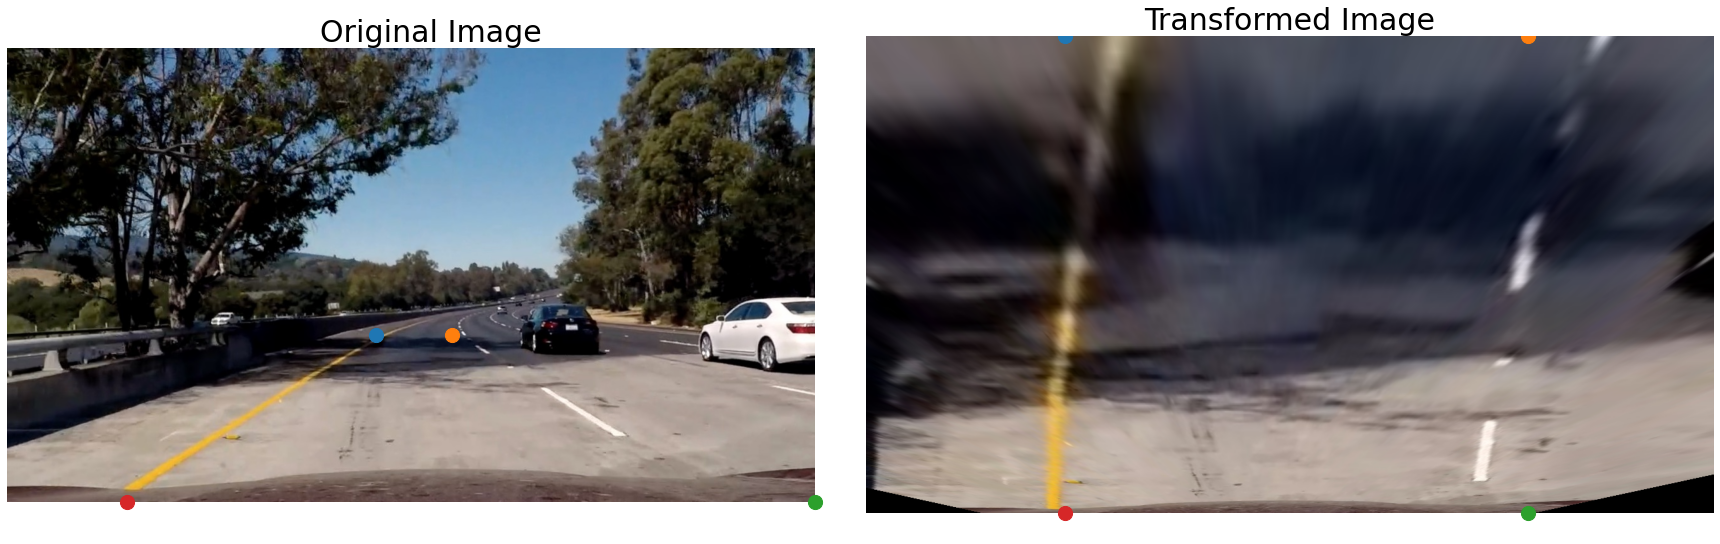

In [80]:
image= mpimg.imread('output_images/test5_undist.jpg')

warped,_,_ = warp(image)
f,(ax1,ax2) = plt.subplots(1,2,figsize=(24, 9))
ax1.imshow(image)
ax1.set_title("Original Image",fontsize=30)
ax1.scatter(585,455,s=200)
ax1.scatter(705,455,s=200)
ax1.scatter(1280,720,s=200)
ax1.scatter(190,720,s=200)

ax1.axis("off")
ax2.imshow(warped)
ax2.set_title("Transformed Image",fontsize=30)
ax2.scatter(300,0,s=200)
ax2.scatter(1000,0,s=200)
ax2.scatter(1000,720,s=200)
ax2.scatter(300,720,s=200)
ax2.axis("off")
f.tight_layout()

In [81]:
#binary image
def color_mask(color_space,low,high):
    mask = cv2.inRange(color_space, low, high)
    return mask
# apply color to the binary image
def apply_color_mask(color_space,img,low,high):
    mask = cv2.inRange(color_space, low, high)
    result = cv2.bitwise_and(img,img, mask= mask)
    return result

In [82]:
image= mpimg.imread('output_images/test5_undist.jpg')

warped,_,_ = warp(image)
img_size=(warped.shape[1],warped.shape[0])
#warped,M,Minv = warp(image)
image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

@widgets.interact(w_h_l = widgets.IntSlider(min=0,max=255,step=1,value=0),
                                w_h_h = widgets.IntSlider(min=0,max=255,step=1,value=255),
                                  w_s_l = widgets.IntSlider(min=0,max=255,step=1,value=0),
                                  w_s_h = widgets.IntSlider(min=0,max=255,step=1,value=32),
                                  w_v_l = widgets.IntSlider(min=0,max=255,step=1,value=180),
                                  w_v_h = widgets.IntSlider(min=0,max=255,step=1,value=255))
def pipe_trial( w_h_l,w_h_h,w_s_l,w_s_h,w_v_l,w_v_h):

    white_hsv_low  = np.array([  w_h_l,   w_s_l,   w_v_l])
    white_hsv_high = np.array([ w_h_h,  w_s_h, w_v_h])

    white_lane = color_mask(image_HSV,white_hsv_low,white_hsv_high)

    f,(ax1,ax2) =plt.subplots(1,2,figsize=(24,9))
    ax1.imshow(warped)
    ax2.imshow(white_lane,cmap="gray")

interactive(children=(IntSlider(value=0, description='w_h_l', max=255), IntSlider(value=255, description='w_h_…

In [83]:
image= mpimg.imread('output_images/test5_undist.jpg')
warped,_,_ = warp(image)
img_size=(warped.shape[1],warped.shape[0])
#warped,M,Minv = warp(image)
image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

@widgets.interact(y_h_l = widgets.IntSlider(min=0,max=255,step=1,value=0),
                                y_h_h = widgets.IntSlider(min=0,max=255,step=1,value=80),
                                  y_s_l = widgets.IntSlider(min=0,max=255,step=1,value=65),
                                  y_s_h = widgets.IntSlider(min=0,max=255,step=1,value=255),
                                #  y_v_l = widgets.IntSlider(min=0,max=255,step=1,value=0),
                                  y_v_l = widgets.IntSlider(min=0,max=255,step=1,value=80),
                                  y_v_h = widgets.IntSlider(min=0,max=255,step=1,value=255))
def pipe_trial(y_h_l,y_h_h,y_s_l,y_s_h,y_v_l,y_v_h):



    yellow_hsv_low  = np.array([ y_h_l, y_s_l, y_v_l])
    yellow_hsv_high = np.array([ y_h_h, y_s_h, y_v_h])

    

    yellow_lane = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    

    f,(ax1,ax2) =plt.subplots(1,2,figsize=(24,9))
    ax1.imshow(warped)
    ax2.imshow(yellow_lane,cmap="gray")

interactive(children=(IntSlider(value=0, description='y_h_l', max=255), IntSlider(value=80, description='y_h_h…

# Putting it together 

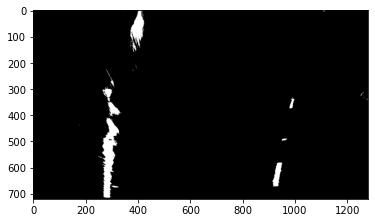

In [84]:
yellow_hsv_low  = np.array([ 18, 80, 0])
yellow_hsv_high = np.array([ 80, 255, 255])

white_hsv_low  = np.array([  4,   0,   207])
white_hsv_high = np.array([ 255,  32, 255])
yellow_lane = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
white_lane = color_mask(image_HSV,white_hsv_low,white_hsv_high)
lane_color = cv2.bitwise_or(yellow_lane,white_lane)
plt.imshow(lane_color,cmap="gray")

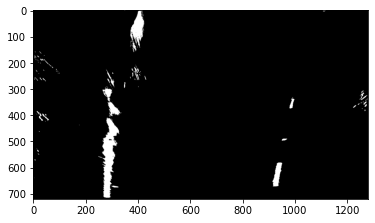

In [85]:
HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)
S= HLS[:,:,2]
sobel_x = abs_sobel_thresh(S, orient='x', sobel_kernel=13 ,thresh_min=90, thresh_max=225)

image_cmb = np.zeros_like(lane_color)
image_cmb[(lane_color>=.5)|(sobel_x>=0.5)]=1
plt.imshow(image_cmb,cmap="gray")

# Add GaussianBlur

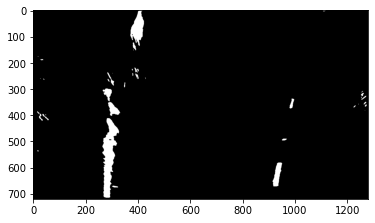

In [86]:
lane_line_gb = cv2.GaussianBlur(image_cmb,(9,9),0)
plt.imshow(lane_line_gb,cmap="gray")

In [87]:
def moving_average(a, n=3):
    #  Moving average 
    ret = np.cumsum(a, dtype=float)
    n = int(n)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n -1:] /n


Text(0, 0.5, 'mean intensity')

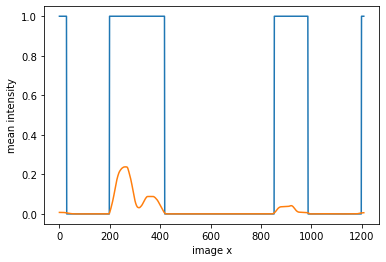

In [88]:
img_size = (lane_line_gb.shape[1],lane_line_gb.shape[0])
mov_filtsize = img_size[1]/10.
mean_lane = np.mean(lane_line_gb,axis=0)
mean_lane = moving_average(mean_lane,mov_filtsize)
plt.plot(mean_lane>0.005)
plt.plot(mean_lane)
plt.xlabel('image x')
plt.ylabel('mean intensity')

# Lane Detection

In [89]:
def initial_mask(img,window_size):
    img_size=(img.shape[1],img.shape[0])
    mov_filtsize = img_size[1]/50.
    temp = int(img_size[1]/2)
    mean_lane = np.mean(img[temp:,:],axis=0)
    mean_lane = moving_average(mean_lane,mov_filtsize)
    
    #find peak indexes from histogram
    indexes = find_peaks_cwt(mean_lane,[100],max_distances=[800])
    
    
    val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
    ind_sorted = np.argsort(-val_ind)

    ind_peakR = indexes[ind_sorted[0]]
    ind_peakL = indexes[ind_sorted[1]]
    
    # exchange indexes if under condition
    if ind_peakR<ind_peakL:
        
        ind_peakR,ind_peakL = ind_peakL,ind_peakR

    # take windows from each index
    ind_min_L = ind_peakL-window_size
    ind_max_L = ind_peakL+window_size

    ind_min_R = ind_peakR-window_size
    ind_max_R = ind_peakR+window_size

    mask_L = np.zeros_like(img)
    mask_R = np.zeros_like(img)

    ind_peakR_prev = ind_peakR
    ind_peakL_prev = ind_peakL
    
    # Split image into 11 parts and compute histogram on each part
    
    for i in range(11):
        img_y1 = int(img_size[0]-img_size[0]*i/11)
        img_y2 = int(img_size[0]-img_size[0]*(i+1)/11)
    
        mean_lane_y = np.mean(img[img_y2:img_y1,:],axis=0)
        mean_lane_y = moving_average(mean_lane_y,mov_filtsize)
        indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        # If the indexes are more than 2 (both side peak L,R)
        if len(indexes)>1.5:
            val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
            ind_sorted = np.argsort(-val_ind)

            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = indexes[ind_sorted[1]]
            if ind_peakR<ind_peakL:
                ind_peakR,ind_peakL = ind_peakL,ind_peakR
        # If one peak is found   
        else:
       
            if len(indexes)==1:
                # Right lane found 
                if (np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev)):
                    ind_peakR = indexes[0]
                    ind_peakL = ind_peakL_prev
                # Left lane found
                else:
                    ind_peakL = indexes[0]
                    ind_peakR = ind_peakR_prev
            # If no pixels are found, use previous ones. 
            else:
                ind_peakL = ind_peakL_prev
                ind_peakR = ind_peakR_prev
            
        # Outlier rejection 
        # If new center is more than 80pixels away, use previous
       
        if np.abs(ind_peakL-ind_peakL_prev)>=80:
            ind_peakL = ind_peakL_prev

        if np.abs(ind_peakR-ind_peakR_prev)>=80:
            ind_peakR = ind_peakR_prev
            
    
            
        mask_L[img_y2:img_y1,ind_peakL-window_size:ind_peakL+window_size] = 1.
        mask_R[img_y2:img_y1,ind_peakR-window_size:ind_peakR+window_size] = 1.
        
        ind_peakL_prev = ind_peakL
        ind_peakR_prev = ind_peakR
        
    return mask_L,mask_R


c:\users\ahmed\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\ahmed\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\ahmed\appdata\local\programs\python\python37-32\lib\site-packages\scipy\signal\_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
c:\users\ahmed\appdata\local\programs\python\python37-32\lib\site-packages\scipy\signal\_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)
c:\users\ahmed\appdata\local\programs\python\python37-32\lib\site-packages\scipy\signal\_peak_finding.py:1185: RuntimeWarning: divide by zero encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[li

Text(0.5, 1.0, 'Right Lane')

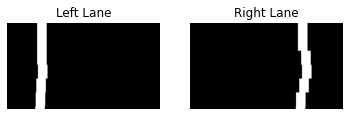

In [90]:
mask_L, mask_R = initial_mask(lane_line_gb, window_size = 40)
plt.subplot(1,2,1)
plt.imshow(mask_L, cmap='gray')
plt.axis('off')
plt.title('Left Lane')
plt.subplot(1,2,2)
plt.imshow(mask_R, cmap='gray')
plt.axis('off')
plt.title('Right Lane')

# Polynomaial fit with lane curvature 

In [91]:
# Polynomial fit function
def polyfit(line,thresh=0.5,lane_range=[5,90]):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    img_size = (line.shape[1],line.shape[0])
    vals = np.argwhere(line > thresh)
    
    all_x = vals.T[0]
    all_y = vals.T[1]
    small,large = np.percentile(all_y,lane_range)
    all_y = all_y[np.where((all_y>small) & (all_y<large))]
    all_x = all_x[np.where((all_y>small) & (all_y<large))]
    fit = np.polyfit(all_x, all_y, 2)
    
    y = np.arange(11)*img_size[1]/10
    fitx = fit[0] * y**2 + fit[1]*y + fit[2]
    fit_cr = np.polyfit(all_x*ym_per_pix, all_y*xm_per_pix, 2)
    y_eval = np.max(all_x)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
    return fitx,y,fit,curverad


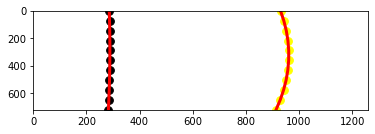

In [92]:
left_fitx , left_y, left_fit,left_curve = polyfit(mask_L,thresh=0.08,lane_range=[5,90])
right_fitx, right_y, right_fit,right_curve = polyfit(mask_R,thresh=0.008,lane_range=[5,95])
ax = plt.subplot(211)

plt.plot(left_fitx,left_y,lw=3,c="r")
plt.plot(right_fitx,right_y,lw=3,c="r")
plt.scatter(left_fitx,left_y,c="black",s=60)
plt.scatter(right_fitx,right_y,c="yellow",s=60)

plt.xlim(0,1260)
plt.ylim(0,720)
ax.invert_yaxis()


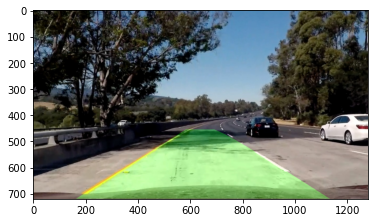

In [93]:
wpb_zero = np.zeros_like(lane_line_gb).astype(np.uint8)
color_warp = np.dstack((wpb_zero, wpb_zero, wpb_zero))
    
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])

pts = np.hstack((pts_left, pts_right))



# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

warped,M,Minv = warp(image)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)
